In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
from requests import get
from bs4 import BeautifulSoup
import time
import acquire
import acquire_df
from acquire import scrape_github_data
import pandas as pd
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import pandas as pd
import acquire
from env import github_token, github_username

In [2]:
df = acquire_df.get_NLP_df()
df

repo      language  \
0            dickreuter/Poker        Python   
1                pret/pokered      Assembly   
2      ishikota/PyPokerEngine        Python   
3      andrewprock/pokerstove           C++   
4           pokerregion/poker        Python   
..                        ...           ...   
495  IMGameDesigner/PokerGame    JavaScript   
496           houen/PokerFace  ActionScript   
497        ngocbd/pokerserver          Java   
498  mikaelbr/AI-Poker-Player        Python   
499    ProPanek/PlanningPoker    JavaScript   

                                       readme_contents  
0    Deep mind pokerbot for pokerstars, partypoker ...  
1    # Pokémon Red and Blue [![Build Status][ci-bad...  
2    # PyPokerEngine\n\n[![Build Status](https://tr...  
3    PokerStove\n==========\n\n[![OpenHUB Metrics](...  
4    Poker framework for Python\n==================...  
..                                                 ...  
495  ### 满意请给个star\n### [1.0原版js](https://github.co...  
496  This [Actionscript Flash poker (5-card & Texas...  
497  # pokerserver\n[![Codacy Badge](https://api.co...  
498  # AI Poker Player\n===========================...  
499  # Planning Poker\n[![Codacy Badge](https://api...  

[500 rows x 3 columns]

In [3]:
df = df.drop_duplicates(subset='readme_contents', keep='first', inplace=False, ignore_index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             456 non-null    object
 1   language         440 non-null    object
 2   readme_contents  456 non-null    object
dtypes: object(3)
memory usage: 14.2+ KB


In [4]:
# Now that I have a dataframe I need to normalize the text using common tools from previous functions to prep the text for parsing

cleaned_df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

cleaned_df.info()

# DataFrame.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             440 non-null    object
 1   language         440 non-null    object
 2   readme_contents  440 non-null    object
dtypes: object(3)
memory usage: 13.8+ KB


In [5]:
cleaned_df.isna().value_counts()

repo   language  readme_contents
False  False     False              440
dtype: int64

In [6]:
cleaned_df.dtypes

repo               object
language           object
readme_contents    object
dtype: object

In [7]:
cleaned_df.readme_contents.astype("str")

0      Deep mind pokerbot for pokerstars, partypoker ...
1      # Pokémon Red and Blue [![Build Status][ci-bad...
2      # PyPokerEngine\n\n[![Build Status](https://tr...
3      PokerStove\n==========\n\n[![OpenHUB Metrics](...
4      Poker framework for Python\n==================...
                             ...                        
495    ### 满意请给个star\n### [1.0原版js](https://github.co...
496    This [Actionscript Flash poker (5-card & Texas...
497    # pokerserver\n[![Codacy Badge](https://api.co...
498    # AI Poker Player\n===========================...
499    # Planning Poker\n[![Codacy Badge](https://api...
Name: readme_contents, Length: 440, dtype: object

In [8]:
cleaned_df = cleaned_df.reset_index()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            440 non-null    int64 
 1   repo             440 non-null    object
 2   language         440 non-null    object
 3   readme_contents  440 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.9+ KB


In [9]:
prepared_df = acquire_df.prepare_poker(cleaned_df.readme_contents)
prepared_df.head()

content  \
0  Deep mind pokerbot for pokerstars, partypoker ...   
1  # Pokémon Red and Blue [![Build Status][ci-bad...   
2  # PyPokerEngine\n\n[![Build Status](https://tr...   
3  PokerStove\n==========\n\n[![OpenHUB Metrics](...   
4  Poker framework for Python\n==================...   

                                     stemmed_content  \
0  deep mind pokerbot pokerstar partypok ggpoker ...   
1  pokemon red blue build statuscibadgeci disasse...   
2  pypokerengin build statushttpstravisciorgishik...   
3  pokerstov openhub metricshttpswwwopenhubnetppo...   
4  poker framework python travi coveral python re...   

                                      lemmed_content  
0  deep mind pokerbot pokerstars partypoker ggpok...  
1  pokemon red blue build statuscibadgeci disasse...  
2  pypokerengine build statushttpstravisciorgishi...  
3  pokerstove openhub metricshttpswwwopenhubnetpp...  
4  poker framework python travis coverall python ...

In [10]:
# now merge the cleaned DF and the original DF, so that we have access to the repo titles and programming language from the original DF 
# as well as the cleaned outputs from the second DF

labeled_df = cleaned_df.merge(prepared_df, how='left', left_on='readme_contents', right_on='content')
#labeled_df = labeled_df.drop(columns='readme_contents')
labeled_df


#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

index                      repo      language  \
0        0          dickreuter/Poker        Python   
1        1              pret/pokered      Assembly   
2        2    ishikota/PyPokerEngine        Python   
3        3    andrewprock/pokerstove           C++   
4        4         pokerregion/poker        Python   
..     ...                       ...           ...   
435    495  IMGameDesigner/PokerGame    JavaScript   
436    496           houen/PokerFace  ActionScript   
437    497        ngocbd/pokerserver          Java   
438    498  mikaelbr/AI-Poker-Player        Python   
439    499    ProPanek/PlanningPoker    JavaScript   

                                       readme_contents  \
0    Deep mind pokerbot for pokerstars, partypoker ...   
1    # Pokémon Red and Blue [![Build Status][ci-bad...   
2    # PyPokerEngine\n\n[![Build Status](https://tr...   
3    PokerStove\n==========\n\n[![OpenHUB Metrics](...   
4    Poker framework for Python\n==================...   
..                                                 ...   
435  ### 满意请给个star\n### [1.0原版js](https://github.co...   
436  This [Actionscript Flash poker (5-card & Texas...   
437  # pokerserver\n[![Codacy Badge](https://api.co...   
438  # AI Poker Player\n===========================...   
439  # Planning Poker\n[![Codacy Badge](https://api...   

                                               content  \
0    Deep mind pokerbot for pokerstars, partypoker ...   
1    # Pokémon Red and Blue [![Build Status][ci-bad...   
2    # PyPokerEngine\n\n[![Build Status](https://tr...   
3    PokerStove\n==========\n\n[![OpenHUB Metrics](...   
4    Poker framework for Python\n==================...   
..                                                 ...   
435  ### 满意请给个star\n### [1.0原版js](https://github.co...   
436  This [Actionscript Flash poker (5-card & Texas...   
437  # pokerserver\n[![Codacy Badge](https://api.co...   
438  # AI Poker Player\n===========================...   
439  # Planning Poker\n[![Codacy Badge](https://api...   

                                       stemmed_content  \
0    deep mind pokerbot pokerstar partypok ggpoker ...   
1    pokemon red blue build statuscibadgeci disasse...   
2    pypokerengin build statushttpstravisciorgishik...   
3    pokerstov openhub metricshttpswwwopenhubnetppo...   
4    poker framework python travi coveral python re...   
..                                                 ...   
435  star 10jshttpsgithubcomimgamedesignerpokergame...   
436  actionscript flash poker 5card texa holdemhttp...   
437  pokerserv codaci badgehttpsapicodacycomproject...   
438  ai poker player initi commit ai poker player s...   
439  plan poker codaci badgehttpsapicodacycomprojec...   

                                        lemmed_content  
0    deep mind pokerbot pokerstars partypoker ggpok...  
1    pokemon red blue build statuscibadgeci disasse...  
2    pypokerengine build statushttpstravisciorgishi...  
3    pokerstove openhub metricshttpswwwopenhubnetpp...  
4    poker framework python travis coverall python ...  
..                                                 ...  
435  star 10jshttpsgithubcomimgamedesignerpokergame...  
436  actionscript flash poker 5card texas holdemhtt...  
437  pokerserver codacy badgehttpsapicodacycomproje...  
438  ai poker player initial commit ai poker player...  
439  planning poker codacy badgehttpsapicodacycompr...  

[440 rows x 7 columns]

In [11]:
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            440 non-null    int64 
 1   repo             440 non-null    object
 2   language         440 non-null    object
 3   readme_contents  440 non-null    object
 4   content          440 non-null    object
 5   stemmed_content  440 non-null    object
 6   lemmed_content   440 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.5+ KB


In [12]:
# labeled_df is the final DF, and I dropped 60 columns due to nulls and duplicate repo issues. This final DF will be used for the explore section
# lets take a look at overall composition by programming language:

def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(labeled_df, "language").tail(10)


,n,percent
Svelte,2,0.004545
Roff,2,0.004545
Vue,2,0.004545
Dart,2,0.004545
F#,1,0.002273
Julia,1,0.002273
Elm,1,0.002273
Apex,1,0.002273
Pascal,1,0.002273
ShaderLab,1,0.002273


In [13]:
# ADDITIONAL_STOPWORDS = []

# def clean(text):
#         'A simple function to cleanup text data'
#         wnl = nltk.stem.WordNetLemmatizer()
#         stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#         text = (unicodedata.normalize('NFKD', text)
#                 .encode('ascii', 'ignore')
#                 .decode('utf-8', 'ignore')
#                 .lower())
#         words = re.sub(r'[^\w\s]', '', text).split()
#         return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [14]:
languages = labeled_df.language.unique()
language_df = {}

for lang in languages:
    language_df[lang] = labeled_df[labeled_df.language == lang].lemmed_content
    language_df[lang] = pd.Series(" ".join(language_df[lang].values).split(' '), name=lang).value_counts()

language_df["Python"]

game            267
poker           232
player          231
hand            200
card            169
               ... 
rival             1
pipinstalled      1
boolean           1
switching         1
midsund           1
Name: Python, Length: 5161, dtype: int64

## Modeling

### Our text to model is going to be the lemmatized text, labeled_df.lemmed_content
- run a TF-IDF with scikit learn, then run all four categories of classification model

In [23]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
# get the basics for math and visuals
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# add the tools for classification reports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# pull in Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# pull in Random Forest classifer
from sklearn.ensemble import RandomForestClassifier
# pull in KNN classifer
from sklearn.neighbors import KNeighborsClassifier
# pull in Logistic Regression classifer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# TF-IDF via scikit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


### For modeling purposes, I am going to drop any language with less than 3 attributed repos. Less than 3 repos will not adequately segment into train, validate and test dataframes.

In [17]:
# labeled_df is the final DF, and I dropped 60 columns due to nulls and duplicate repo issues. This final DF will be used for the explore section
# lets take a look at overall composition by programming language:

def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(labeled_df, "language").tail(10)

,n,percent
Svelte,2,0.004545
Roff,2,0.004545
Vue,2,0.004545
Dart,2,0.004545
F#,1,0.002273
Julia,1,0.002273
Elm,1,0.002273
Apex,1,0.002273
Pascal,1,0.002273
ShaderLab,1,0.002273


In [18]:
values =['ShaderLab', 'Pascal', 'Apex', 'Elm', 'Julia', 'F#', 'Kotlin', 'Shell', 
'CoffeeScript', 'Lua', 'Svelte', 'Roff', 'Vue', 'Dart']

labeled_df = labeled_df[labeled_df.language.isin(values) == False]


In [19]:
# let's check that it worked
show_counts_and_ratios(labeled_df, "language").tail(10)

,n,percent
Swift,6,0.014354
Elixir,5,0.011962
HTML,5,0.011962
ActionScript,4,0.009569
CSS,4,0.009569
Clojure,4,0.009569
Rust,4,0.009569
Erlang,3,0.007177
Objective-C,3,0.007177
Scala,3,0.007177


In [20]:
 #labeled_df.lemmed_content
 # lemmed
 # language
 # tfidf
 # train test split
 #

In [21]:
# split the data
train, validate, test = acquire_df.train_validate_test_split(labeled_df, 'language')

train.shape[0], validate.shape[0], test.shape[0]

(233, 101, 84)

In [27]:
train.columns

Index(['index', 'repo', 'language', 'readme_contents', 'content',
       'stemmed_content', 'lemmed_content'],
      dtype='object')

In [37]:
# create the object
tfidf = TfidfVectorizer()

# fit the vectorizer on all the lemmed_content
X = tfidf.fit_transform(labeled_df.lemmed_content)

y = labeled_df.language
labeled_df = labeled_df.rename(columns={'language': 'programming_language_99'})


In [38]:
# make the df out of the sparse matrix from TDIDF vectorizer
tfidf_df = pd.DataFrame(X.todense(), columns = tfidf.get_feature_names())
# concats with language lables
encoded_df = pd.concat([tfidf_df, labeled_df.programming_language_99.reset_index()], axis=1)

encoded_df.head(1)

,00,000,0000,000000,00005,000050001,0001,000126,000176,0002,...,zoom,zoomed,zoorlcardmodels,zopehttpsgithubcomadzo261,zshenv,zubats,zune,zypper,index,programming_language_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Python


In [35]:
encoded_df = encoded_df.reset_index()

In [39]:
values =['ShaderLab', 'Pascal', 'Apex', 'Elm', 'Julia', 'F#', 'Kotlin', 'Shell', 
'CoffeeScript', 'Lua', 'Svelte', 'Roff', 'Vue', 'Dart']

encoded_df = encoded_df[encoded_df.programming_language_99.isin(values) == False]
encoded_df.head()


,00,000,0000,000000,00005,000050001,0001,000126,000176,0002,...,zoom,zoomed,zoorlcardmodels,zopehttpsgithubcomadzo261,zshenv,zubats,zune,zypper,index,programming_language_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Python
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Assembly
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Python
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,C++
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Python


In [40]:

train, validate, test = acquire_df.train_validate_test_split(encoded_df, 'programming_language_99')
train.head(2)

,00,000,0000,000000,00005,000050001,0001,000126,000176,0002,...,zoom,zoomed,zoorlcardmodels,zopehttpsgithubcomadzo261,zshenv,zubats,zune,zypper,index,programming_language_99
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,327,JavaScript
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119,TypeScript


In [41]:

X_train = train.drop(columns=['index', 'programming_language_99'])
y_train = train.programming_language_99

X_validate = validate.drop(columns=['index','programming_language_99'])
y_validate = validate.programming_language_99

X_test = test.drop(columns=['index', 'programming_language_99'])
y_test = test.programming_language_99


## Decision Tree Model

In [42]:
# create an empty list to store the dictionaries
max_depth_list = []
reports = []

# write the for loop to sequentially loop through the values for i,
# setting i as the value, or inverse value, for 
for i in range(1, 11):
        # create the decision tree object with desired hyper-parameters:
        clf = DecisionTreeClassifier(max_depth=i)
    
        # fit the decision tree to the training data:
        clf = clf.fit(X_train, y_train)
    
        #make predictions:
        language_prediction = pd.DataFrame(clf.predict(X_train))
        
        # Predict probability
        language_prediction_proba = pd.DataFrame(clf.predict_proba(X_train))
        
        # compute the estimate accuracy
        train_set_accuracy = clf.score(X_train, y_train)
    
        #evaluate on out-of-sample-date
        validate_set_accuracy = clf.score(X_validate, y_validate)
    
        max_depth_list.append({
                            'max_depth': i,
                            'training_accuracy': train_set_accuracy,
                            'validate_accuracy': validate_set_accuracy
                                    })
df = pd.DataFrame(max_depth_list)
df['difference'] = (df.training_accuracy - df.validate_accuracy)
df.sort_values(['validate_accuracy','difference'], ascending=[False, True]).head(3)


,max_depth,training_accuracy,validate_accuracy,difference
8,9,0.613734,0.425743,0.187991
9,10,0.635193,0.425743,0.209451
4,5,0.527897,0.396040,0.131857


<Figure size 864x648 with 0 Axes>

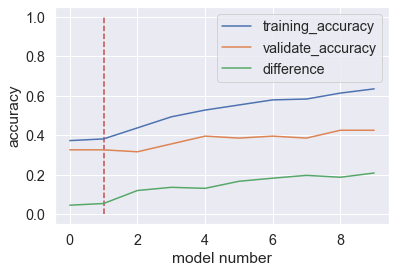

In [43]:
# I selected model #1 because it had the lowest train/val difference of the top 3 performing DTC classifiers
plt.figure(figsize=(12, 9))
sns.set(font_scale = 1.3)
df[['training_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.ylabel("accuracy")
plt.xlabel("model number")
plt.vlines(x=[1], ymin=0, ymax=1, colors='r', linestyles='dashed')
plt.show()

## Random Forest Classifier

In [44]:
# create an empty list to store the dictionaries
max_depth_and_leaf_samples_list = []
# write the for loop to sequentially loop through the values for i,
# setting i as the value, or inverse value, for 
for i in range(1, 16):
    for j in range(1, 16):
        # create the random forest object with desired hyper-parameters:
        rf = RandomForestClassifier(max_depth=i, min_samples_leaf=j)
        # fit the random forest to the training data:
        rf.fit(X_train, y_train)
        # Evaluate importance, or weight, of each feature.
        rf.feature_importances_
        # Classify each passenger by its estimated survival.
        y_pred = rf.predict(X_train)
        # Estimate the probability of survival, using the training data.
        y_pred_proba = rf.predict_proba(X_train)
        # compute the estimate accuracy
        train_set_accuracy = rf.score(X_train, y_train)
        #evaluate on out-of-sample-date
        validate_set_accuracy = rf.score(X_validate, y_validate)
        max_depth_and_leaf_samples_list.append({
                            'max_depth': i,
                            'min_samples_leaf': j,
                            'training_accuracy': train_set_accuracy,
                            'validate_accuracy': validate_set_accuracy,
                            'difference': (train_set_accuracy - validate_set_accuracy)
                                    })

In [45]:
df = pd.DataFrame(max_depth_and_leaf_samples_list)
df.sort_values(['validate_accuracy', 'difference'], ascending = [False, True]).head(3)

,max_depth,min_samples_leaf,training_accuracy,validate_accuracy,difference
182,13,3,0.562232,0.386139,0.176093
168,12,4,0.489270,0.376238,0.113033
197,14,3,0.583691,0.376238,0.207453


<Figure size 1080x720 with 0 Axes>

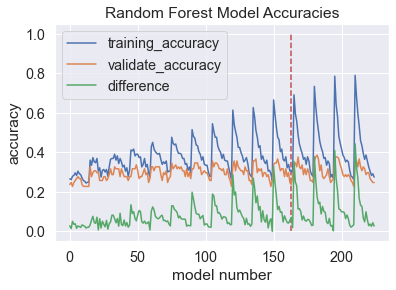

In [46]:
# I selected model #163 because it had the lowest train/val difference of the top 3 performing RFM classifiers
plt.figure(figsize=(15, 10))
sns.set(font_scale = 1.3)
df[['training_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.title("Random Forest Model Accuracies")
plt.ylabel("accuracy")
plt.xlabel("model number")
plt.vlines(x=[163], ymin=0, ymax=1, colors='r', linestyles='dashed')
plt.show()

<div class="alert alert-block alert-success"> 
    <b>Note</b>: I selected model #163 because it had the lowest train/val difference of the top 3 performing RFM classifiers.
</div>

## 3. Logistic Regression Classifier 

### A. Fit the model and loop through C-values

In [47]:
log_regress_outputs = []
i = 1
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=i, random_state=123, intercept_scaling=1, solver='lbfgs')
# Fit the Logistic Regression model
logit.fit(X_train, y_train)
# Get the predictions from the Logistic Regression Model
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)
# compute the estimate accuracy
train_set_accuracy = logit.score(X_train, y_train)
#evaluate on out-of-sample-data
validate_set_accuracy = logit.score(X_validate, y_validate)
log_regress_outputs.append({
                            'c_values': i,
                            'training_accuracy': train_set_accuracy,
                            'validate_accuracy': validate_set_accuracy,
                            'train_val_diff': (train_set_accuracy - validate_set_accuracy)
                                })

In [48]:
df_log_regress = pd.DataFrame(log_regress_outputs)
df_log_regress.sort_values(['validate_accuracy', 'train_val_diff'], ascending = [False, True]).head(3)

,c_values,training_accuracy,validate_accuracy,train_val_diff
0,1,0.575107,0.376238,0.19887


## Takeaway:
- the best perfoming classifier was a Decision Tree Classifier with a max depth value of 9
- however, the most robust DTC model was max depth 5, with a train/val difference of 13%, vs the higher performing model's 18.7% train/val difference.
- Due to the higher reliability predicting performance on the out-of-sample validation data, I'm going to deploy the more robust DTC model with max depth 5 on the test data, for the final prediction

In [55]:
# create an empty list to store the dictionaries
max_depth_list = []
reports = []
i = 5
# write the for loop to sequentially loop through the values for i,
# setting i as the value, or inverse value, for 
        # create the decision tree object with desired hyper-parameters:
clf = DecisionTreeClassifier(max_depth=i)

# fit the decision tree to the training data:
clf = clf.fit(X_train, y_train)

#make predictions:
language_prediction = pd.DataFrame(clf.predict(X_train))

# Predict probability
language_prediction_proba = pd.DataFrame(clf.predict_proba(X_train))

# compute the estimate accuracy
train_set_accuracy = clf.score(X_train, y_train)

#evaluate on out-of-sample-date
validate_set_accuracy = clf.score(X_validate, y_validate)

#evaluate on out-of-sample-date
test_set_accuracy = clf.score(X_test, y_test)

max_depth_list.append({
                        'max_depth': i,
                        'training_accuracy': train_set_accuracy,
                        'validate_accuracy': validate_set_accuracy,
                        'test_accuracy': test_set_accuracy
                                })
df = pd.DataFrame(max_depth_list)
df['train_difference'] = (df.training_accuracy - df.validate_accuracy)
df['test_difference'] = (df.validate_accuracy - df.test_accuracy)
df

,max_depth,training_accuracy,validate_accuracy,test_accuracy,train_difference,test_difference
0,5,0.527897,0.39604,0.392857,0.131857,0.003182
